# sentencepiece 모델 학습을 위한 이전 단계

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [2]:
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


/tmp/ipykernel_2383/390535405.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


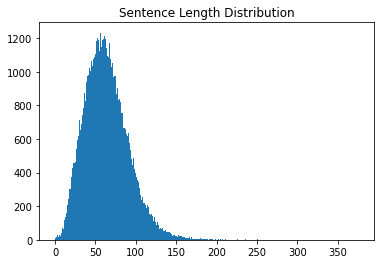

In [3]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set을 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

/tmp/ipykernel_2383/1483434014.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


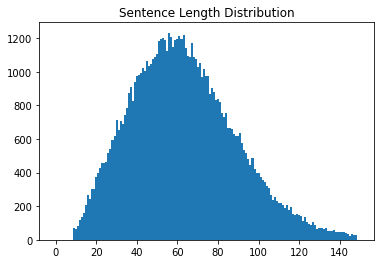

In [4]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# sentencepiece 모델 학습

In [5]:
import sentencepiece as spm
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 9000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=9000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 9000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 396495 Mar 16 06:11 korean_spm.model
-rw-r--r-- 1 root root 166667 Mar 16 06:11 korean_spm.vocab


In [6]:
#위에서 학습시킨 모델 저장 및 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [7]:
# 사용예시
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1199, 11, 315, 7, 3493, 11, 291, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# tokenizer함수 작성

In [8]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [9]:
# 사용 예시
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1857 5698    5    4 8975 1911    3    0    0    0    0    0    0    0]
 [ 102 1573   95    4    0  497   11    4   14    0 1894    3    3    3]]


# 네이버 영화리뷰 감정분석에 sentencepiece 적용

In [10]:
#리뷰파일 불러오기
import pandas as pd
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [11]:
print(train_data["document"].nunique())
train_data.drop_duplicates(subset=['document'], inplace=True) # drop_duplicates 활용
print(len(train_data))

146182
146183


중복을 제거했는데 갯수가 하나 늘어남.

In [12]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


25857번의 NaN 값 삭제

In [13]:
train_data = train_data.dropna(how="any")
#null값 확인
print(train_data.isnull().values.any())

False


In [14]:
#test도 train과 같은 절차
print(test_data["document"].nunique())
test_data.drop_duplicates(subset=['document'], inplace=True) # drop_duplicates 활용
print(len(test_data))

49157
49158


마찬가지로 중복제거했는데 값 늘어남

In [15]:
test_data.loc[test_data.document.isnull()]

,id,document,label
5746,402110,NaN,1


In [16]:
test_data = test_data.dropna(how="any")

위까지 train_data, test_data 결측치 제거됨

In [17]:
train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
train_data["document"].replace("",np.nan, inplace=True) #공백을 null로 변경
train_data = train_data.dropna(how="any")
print('train 샘플의 개수 :',len(train_data))

/tmp/ipykernel_2383/2729449265.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")


train 샘플의 개수 : 145393


In [18]:
test_data["document"] = test_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
test_data["document"].replace("",np.nan, inplace=True) #공백을 null로 변경
test_data = test_data.dropna(how="any")
print('test 샘플의 개수 :',len(test_data))

test 샘플의 개수 : 48852


/tmp/ipykernel_2383/1508181689.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data["document"] = test_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")


In [19]:
train_data.head()

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


In [20]:
test_data.head()

,id,document,label
0,6270596,굳ㅋ,1
2,8544678,뭐야이평점들은나쁘진않지만점짜리는더더욱아니잖아,0
3,6825595,지루하지는않은데완전막장임돈주고보기에는,0
4,6723715,만아니었어도별다섯개줬을텐데왜로나와서제심기를불편하게하죠,0
5,7898805,음악이주가된최고의음악영화,1


문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 49


/tmp/ipykernel_2383/101814941.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


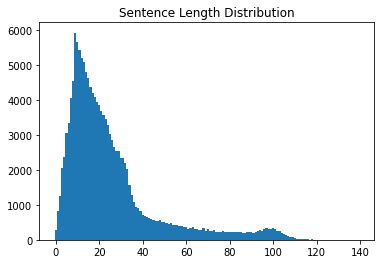

In [21]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data["document"]:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data["document"]:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [22]:
max_len = 50
min_len = 5

# 길이 조건에 맞는 문장만 선택
filtered_train = [s for s in train_data["document"] if (len(s) < max_len) & (len(s) >= min_len)]
filtered_test = [s for s in test_data["document"] if (len(s) < max_len) & (len(s) >= min_len)]

filtered_train = list(set(filtered_train))
filtered_test =  list(set(filtered_test))

train_df = pd.DataFrame(filtered_train)
test_df = pd.DataFrame(filtered_test)

In [23]:
# 길이 50이하인 데이터를 기존 데이터와 병합합니다.

#inner로 만들면 nan을 생성하지 않는, 겹치는 부분만 병합
#outer로 만들면 nan을 생성하는 것을 포함하는, 겹치지 않는 부분도 병합
new_train_df = pd.merge(train_data, train_df, how='inner', left_on='document', right_on=0)
new_test_df = pd.merge(test_data, test_df, how='inner', left_on='document', right_on=0)

train_data = new_train_df[['id', 'document', 'label']]
test_data = new_test_df[['id', 'document', 'label']]

In [25]:
train_data

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,5403919,막걸음마뗀세부터초등학교학년생인살용영화ㅋㅋㅋ별반개도아까움,0
...,...,...,...
123436,9458520,디케이드다음에더블다음에오즈인데더블은조금밖에안나오네요,1
123437,6222902,인간이문제지소는뭔죄인가,0
123438,9311800,이게뭐요한국인은거들먹거리고필리핀혼혈은착하다,0
123439,2376369,청춘영화의최고봉방황과우울했던날들의자화상,1


In [28]:
#X_train, X_test로도 지정할 수 있지만, 불필요하게 하나에 모두 담기는 것을 방지하기위해 각각 나눔
X_train,X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
X_test,X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])

In [32]:
#라벨설정
y_train = np.array(list(train_data["label"]))
y_test = np.array(list(test_data["label"]))

In [33]:
#sp_tokenizer 함수에서 패딩 = post로 지정됨
X_train[:1]

array([[ 143,  398, 2527,  162, 4796, 4796,  798,   69,  538,  486, 1137,
         131,   47,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [34]:
#위 train_data의 라벨과 일치
y_train[:3]

array([0, 1, 0])

In [36]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

123441
123441
41328
41328


In [37]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델학습 - RNN

In [39]:
#rnn 사용
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 변경가능함
rnn_model.add(tf.keras.layers.Dense(12, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          144000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 12)                396       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 150,681
Trainable params: 150,681
Non-trainable params: 0
_________________________________________________________________


In [40]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = rnn_model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_input, val_target),
                    verbose=1)

Epoch 1/20
483/483 [==============================] - 34s 63ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5029
Epoch 2/20
483/483 [==============================] - 30s 62ms/step - loss: 0.5851 - accuracy: 0.6512 - val_loss: 0.4427 - val_accuracy: 0.7950
Epoch 3/20
483/483 [==============================] - 30s 62ms/step - loss: 0.4378 - accuracy: 0.7977 - val_loss: 0.4164 - val_accuracy: 0.8075
Epoch 4/20
483/483 [==============================] - 30s 61ms/step - loss: 0.4070 - accuracy: 0.8111 - val_loss: 0.3837 - val_accuracy: 0.8235
Epoch 5/20
483/483 [==============================] - 30s 62ms/step - loss: 0.3847 - accuracy: 0.8224 - val_loss: 0.3619 - val_accuracy: 0.8362
Epoch 6/20
483/483 [==============================] - 30s 62ms/step - loss: 0.3708 - accuracy: 0.8307 - val_loss: 0.3527 - val_accuracy: 0.8430
Epoch 7/20
483/483 [==============================] - 30s 62ms/step - loss: 0.3585 - accuracy: 0.8383 - val_loss: 0.3418 - val_accuracy:

In [41]:
r_results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(r_results)

1292/1292 - 8s - loss: 0.4551 - accuracy: 0.8173
[0.45505931973457336, 0.8173393607139587]


test에서 80%의 정확도가 나왔다. konlpy의 mecab를 이용해서 sentencepiece와 비교하고자 한다

# konlpy의 mecab 사용

In [43]:
from konlpy.tag import Mecab

mecab = Mecab()

In [47]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_train = []

for kor in train_data['document']:
    mecab_train.append(mecab_split(kor))

In [48]:
#확인
mecab_train[:4]

[['아', '더', '빙', '진짜', '짜증', '나', '네', '요목', '소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없', '다', '평점', '조정']]

In [49]:
mecab_test = []

for kor in test_data['document']:
    mecab_test.append(mecab_split(kor))
    
mecab_test[:4]

[['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '나쁘',
  '진',
  '않',
  '지만',
  '점',
  '짜리',
  '는',
  '더더욱',
  '아니',
  '잖아'],
 ['지루',
  '하',
  '지',
  '는',
  '않',
  '은데',
  '완전',
  '막장',
  '임',
  '돈',
  '주',
  '고',
  '보',
  '기',
  '에',
  '는'],
 ['만',
  '아니',
  '었',
  '어도',
  '별',
  '다섯',
  '개',
  '줬',
  '을',
  '텐데',
  '왜',
  '로',
  '나와서',
  '제',
  '심기',
  '를',
  '불편',
  '하',
  '게',
  '하',
  '죠'],
 ['음악', '이', '주가', '된', '최고', '의', '음악', '영화']]

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(mecab_train)

In [54]:
#word_index는 단어를 키-값의 딕셔너리를 전체 반환 전체 47079개가 나오므로 실행은 하지않음
#print(tokenizer.word_index)

In [58]:
threshold = 4
total_count = len(tokenizer.word_index) # 단어의 수
rare_count = 0 # threshold값보다 빈도수가 작은 단어의 개수를 카운트
total_frequency = 0 #훈련 데이터의 전체 단어 빈도수 총 합
rare_frequency = 0 #등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 합

for key, value in tokenizer.word_counts.items():
    total_frequency = total_frequency + value
    
    if(value<threshold):
        rare_count +=1
        rare_frequency +=value
        
print('단어 집합(vocabulary)의 크기 :',total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_frequency / total_frequency)*100)

단어 집합(vocabulary)의 크기 : 47079
등장 빈도가 3번 이하인 희귀 단어의 수: 33441
단어 집합에서 희귀 단어의 비율: 71.031670171414
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.055964067469061


In [59]:
# 전체 단어 개수 중 빈도수 3이하인 단어는 제거
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_count - rare_count + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 13639


In [64]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(mecab_train)
X_train = tokenizer.texts_to_sequences(mecab_train)
X_test = tokenizer.texts_to_sequences(mecab_test)

In [65]:
# 타겟데이터 분리
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [66]:
# 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업
# 단어 길이가 0인 것들을 drop
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [67]:
# 빈 샘플들을 제거한 후의 샘플 갯수 확인
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

122889
122889


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [68]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [73]:
# 길이 28 이하의 평점이 몇 %인지 확인
max_len = 28
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 28 이하인 샘플의 비율: 98.36030889664656


In [74]:
# 모든 샘플의 길이를 28로 설정
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# RNN 모델 사용 - 위에서 사용했던 sentencepiece와 동일한 모델구조 사용

In [75]:
#rnn 사용
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

rnn_model2 = tf.keras.Sequential()
rnn_model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model2.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 변경가능함
rnn_model2.add(tf.keras.layers.Dense(12, activation='relu'))
rnn_model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          144000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 12)                396       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 150,681
Trainable params: 150,681
Non-trainable params: 0
_________________________________________________________________


In [76]:
rnn_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = rnn_model2.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_input, val_target),
                    verbose=1)

Epoch 1/20
481/481 [==============================] - 23s 43ms/step - loss: 0.4331 - accuracy: 0.7976 - val_loss: 1.1464 - val_accuracy: 0.4843
Epoch 2/20
481/481 [==============================] - 20s 42ms/step - loss: 0.3373 - accuracy: 0.8530 - val_loss: 1.0648 - val_accuracy: 0.4817
Epoch 3/20
481/481 [==============================] - 20s 42ms/step - loss: 0.3117 - accuracy: 0.8650 - val_loss: 1.1327 - val_accuracy: 0.4880
Epoch 4/20
481/481 [==============================] - 20s 41ms/step - loss: 0.2897 - accuracy: 0.8741 - val_loss: 1.7851 - val_accuracy: 0.4951
Epoch 5/20
481/481 [==============================] - 20s 42ms/step - loss: 0.2689 - accuracy: 0.8839 - val_loss: 1.4577 - val_accuracy: 0.4956
Epoch 6/20
481/481 [==============================] - 20s 42ms/step - loss: 0.2499 - accuracy: 0.8928 - val_loss: 0.8996 - val_accuracy: 0.4942
Epoch 7/20
481/481 [==============================] - 20s 42ms/step - loss: 0.2332 - accuracy: 0.9009 - val_loss: 0.8229 - val_accuracy:

In [77]:
r2_results = rnn_model2.evaluate(X_test,  y_test, verbose=2)

print(r2_results)

1292/1292 - 6s - loss: 0.9012 - accuracy: 0.8210
[0.9011812806129456, 0.8210172057151794]


# 회고

* sentencepiece를 사용했을 때 보다 0.4%정도가 올랐다(0.8173->0.8210)
* 결과적으로 형태소 분석기를 활용한 모델이 sentencepiece보다 더 좋은 결과가 나온 것은 예상을 했다.
* 그럼에도 sentencepiece를 사용하는 이유는 oov(out of vocabulary)문제에 대해서도 robust하고, 언어에 대한 부가지식이 없어도 쉽게 작업을 할 수 있다는 장점이 있기에 사용한다고 한다.
* 이러한 점에서 동일한 모델구조를 사용할 때 위에서 설명한 대로의 결과를 얻는 것은 당연하다고 할 수 있다.
* 이전에 했던 프로젝트임에도 불구하고 많이 헤맸었다. 다른 형태소 분석기를 이용할 뿐인데 train, test를 나누는 부분이라던지, vocab_size를 설정한다든지... 여러가지 문제가 있었고 지금도 의문이 많이 남는다. 프로젝트를 처음부터 보면서 모르는 부분을 최대한 이해하도록 해야겠다.